# Benchmarking lung integration

Here we walkthrough applying the integration benchmarking metrics on the lung atlas example from the [scIB paper](https://www.nature.com/articles/s41592-021-01336-8).

In [18]:
import numpy as np
import scanpy as sc

from scib_metrics.benchmark import Benchmarker

%matplotlib inline

## Load and preprocess data

In [17]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="batch")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/scanpy/preproces

We subset to the highly variable genes so that each method has the same input.

In [5]:
adata = adata[:, adata.var.highly_variable].copy()

In [6]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

## Run methods

Here we run a few embedding-based methods. By focusing on embedding-based methods, we can substantially reduce the runtime of the benchmarking metrics.

In principle, graph-based integration methods can also be benchmarked on some of the metrics that have graph inputs. Future work can explore using graph convolutional networks to embed the graph and then using the embedding-based metrics.

### Scanorama

In [7]:
%%capture
import scanorama

# List of adata per batch
batch_cats = adata.obs.batch.cat.categories
adata_list = [adata[adata.obs.batch == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs.batch == b] = adata_list[i].obsm["X_scanorama"]

### Liger

In [8]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.batch == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.batch == b] = liger_data.adata_list[i].obsm["H_norm"]

/home/adam/miniconda3/envs/scib-metrics/lib/python3.10/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [02:17<00:00,  4.59s/it]


### Harmony

In [9]:
from harmony import harmonize

adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
	Completed 10 / 10 iteration(s).


### scVI

In [10]:
%%capture
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=246` reached.


### scANVI

In [11]:
%%capture
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)
lvae.train(max_epochs=20, n_samples_per_label=100)
adata.obsm["scANVI"] = lvae.get_latent_representation()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.accelerators.cuda:You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Perform the benchmark

In [12]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "Scanorama", "LIGER", "Harmony", "scVI", "scANVI"],
    n_jobs=6,
)
bm.benchmark()

Embeddings: 100%|██████████| 6/6 [01:46<00:00, 17.77s/it]


### Visualize the results

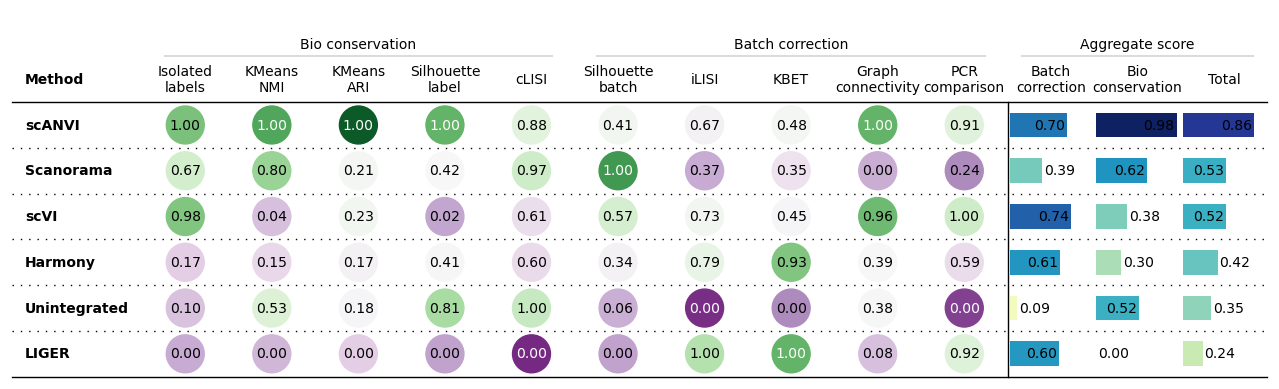

In [19]:
bm.plot_results_table()

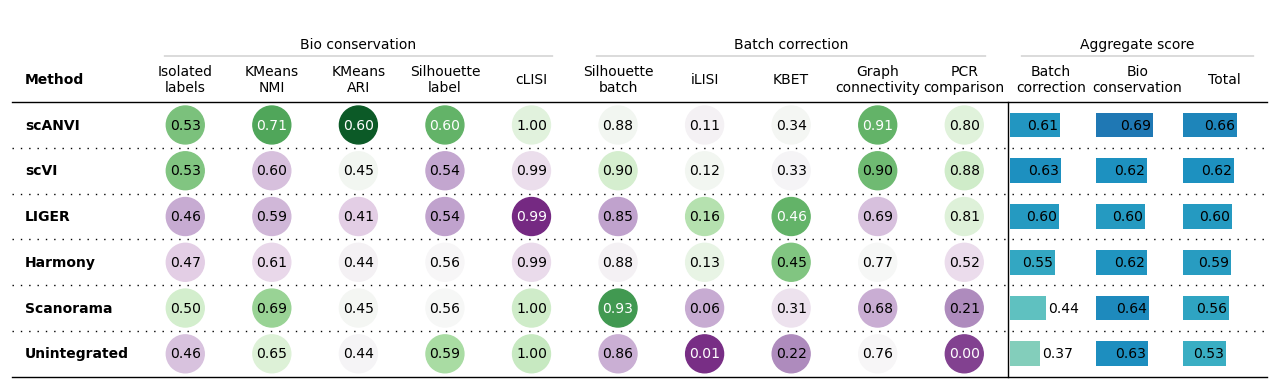

In [20]:
bm.plot_results_table(min_max_scale=False)

We can also access the underlying dataframes to print the results ourselves.

In [15]:
from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                            
Unintegrated          0.464394          0.654386          0.442916   
Scanorama             0.504315          0.685718          0.450299   
LIGER                  0.45722          0.593406          0.408749   
Harmony                0.46885          0.610796          0.440707   
scVI                  0.526255          0.597475          0.452404   
scANVI                0.527354          0.709471          0.602122   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

              Silhouette label             cLISI  Silhouette batch  \
Embedding                                                            
Unintegrated          0.585415               1.0          0.855258   
Scanorama             0.564586          0.999625          0.932109   
LIGER                 0.542106          0.985223          0.850703   
Harmony                0.56432          0.994074          0.878664   
scVI                  0.543061          0.994309          0.897465   
scANVI                0.595713          0.998238          0.884396   
Metric Type   Bio conservation  Bio conservation  Batch correction   

                         iLISI              KBET Graph connectivity  \
Embedding                                                             
Unintegrated          0.007811          0.223815           0.764953   
Scanorama             0.064213          0.308119           0.675554   
LIGER                 0.161164          0.463056           0.694717   
Harmony                0.12853           0.44529           0.765538   
scVI                  0.119576          0.331022           0.899629   
scANVI                0.110701          0.339256           0.907899   
Metric Type   Batch correction  Batch correction   Batch correction   

                PCR comparison Batch correction Bio conservation  \
Embedding                                                          
Unintegrated                 0         0.370367         0.629422   
Scanorama              0.21128         0.438255         0.640908   
LIGER                 0.810099         0.595948         0.597341   
Harmony               0.522324         0.548069          0.61575   
scVI                  0.879229         0.625384         0.622701   
scANVI                0.798182         0.608087         0.686579   
Metric Type   Batch correction  Aggregate score  Aggregate score   

                        Total  
Embedding                      
Unintegrated           0.5258  
Scanorama            0.559847  
LIGER                0.596784  
Harmony              0.588678  
scVI                 0.623774  
scANVI               0.655182  
Metric Type   Aggregate score

In [16]:
df.transpose()

Embedding,Unintegrated,Scanorama,LIGER,Harmony,scVI,scANVI,Metric Type
Isolated labels,0.464394,0.504315,0.45722,0.46885,0.526255,0.527354,Bio conservation
KMeans NMI,0.654386,0.685718,0.593406,0.610796,0.597475,0.709471,Bio conservation
KMeans ARI,0.442916,0.450299,0.408749,0.440707,0.452404,0.602122,Bio conservation
Silhouette label,0.585415,0.564586,0.542106,0.56432,0.543061,0.595713,Bio conservation
cLISI,1.0,0.999625,0.985223,0.994074,0.994309,0.998238,Bio conservation
Silhouette batch,0.855258,0.932109,0.850703,0.878664,0.897465,0.884396,Batch correction
iLISI,0.007811,0.064213,0.161164,0.12853,0.119576,0.110701,Batch correction
KBET,0.223815,0.308119,0.463056,0.44529,0.331022,0.339256,Batch correction
Graph connectivity,0.764953,0.675554,0.694717,0.765538,0.899629,0.907899,Batch correction
PCR comparison,0,0.21128,0.810099,0.522324,0.879229,0.798182,Batch correction
